Regressions between ERA5 (dif. variables) and Cloud Index (CI) in Corrientes Argentina

The anomalies are estimated in ERA5_regression_preprocess.ipynb

In this code, the regressions are estimated and plotted

* Annually
* For each season seperatelly (estimating first the seasonal mean)


In [1]:
import os
import pandas as pd 
import datetime 
import numpy as np

import iris
#from iris.analysis import MEAN
#from iris.analysis.stats import pearsonr
import iris.coord_categorisation

import scipy
from scipy.stats import theilslopes #theil-sen trends
from scipy.stats import linregress

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import iris.plot as iplt
import cmocean

import f_Iris
from f_mis_shapes import df_paises
#import esmvalcore.preprocessor as ep 

In [2]:
# directories
cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))

#si estoy trabajando desde el servidor vegeta
ruta_a_archivos_ERA5_mensual = "/pikachu/datos/nadia.testani/Doctorado/datos/ERA5/mon/SAm" #ruta donde estan los archivos con datos de ERA5
ruta_a_archivos_ERA5_mensual_ori = "/datos/ERA5_updated/mon" #ruta donde estan los archivos con datos de ERA5 originales
ruta_a_archivos_CI = "/pikachu/datos/nadia.testani/Doctorado/resultados/resultados2021/nubosidad/paper"
ruta_a_archivos_smn = "/pikachu/datos/nadia.testani/Doctorado/datos/smn"
ruta_a_archivos_ISCCP = "/pikachu/datos2/isccp-h/HGM"
ruta_a_resultados = "/pikachu/datos/nadia.testani/Doctorado/resultados/resultados2024" #ruta donde se guardan los resultados del analisis de nubosidad

Current working directory: /home/nadia.testani/Doctorado/DoctoradoCodigos/codigos2024


In [3]:
#functions
def f_regression(serie_df, cube):
    """
    serie_df: dataframe e.g. CI
    cube: iris cube
    """
    series = np.array(serie_df.copy())
    cube_data = np.array(cube.copy().data)
    cube_reshaped = cube_data.reshape(cube_data.shape[0], -1) # Reshape the cube data to 2D (time x space)

    # Perform linear regression for each grid point
    regression_r = []
    regression_pvalues = []
    for point_data in cube_reshaped.T:
        slope, intercept, r_value, p_value, std_err = linregress(series.flatten(), point_data)
        regression_r.append(r_value)
        regression_pvalues.append(p_value)

    # Convert the results to a NumPy array with the same shape as the original cube
    r_array = np.array(regression_r).reshape(1,cube_data.shape[1],cube_data.shape[2])
    pvalues_array = np.array(regression_pvalues).reshape(1,cube_data.shape[1],cube_data.shape[2])

    # Create a new Iris cube with the regression results
    r_cube = cube[0:1,:,:].copy(data=r_array)
    pvalues_cube = cube[0:1,:,:].copy(data=pvalues_array)

    return(r_cube, pvalues_cube)


In [4]:
fecha_inicio_climatologia_str = "1983-12-15"
fecha_final_climatologia_str = "2016-11-15"

In [5]:
#Cloud Index
CI = pd.read_csv(f"{ruta_a_archivos_smn}/CI_detrend_anom_ref198312to201611.csv") #from 1961-01-01 until 2021-11-01

#set dates as index
CI = CI.set_index(CI["Unnamed: 0"]) 
CI = CI.drop(["Unnamed: 0"], axis = 1)
CI.index = pd.DatetimeIndex(CI.index)

#CI dates
date_i_CI = CI.index[0]
date_f_CI = CI.index[-1]

In [6]:
#regression of CI and t2m ERA5
file_dir = ruta_a_archivos_ERA5_mensual
variable_name = "t2m"
file_name = f"{variable_name}_detrend_anoms.nc"
cube = iris.load_cube(f"{file_dir}/{file_name}")
#regression
r_cube, pvalues_cube = f_regression(CI, cube)


In [50]:
from cartopy.io import shapereader
from shapely.geometry.multipolygon import MultiPolygon
import geopandas as gpd
df_paises = gpd.read_file(shapereader.natural_earth('10m', 'cultural', 'admin_0_countries')) # cargo paises de natural_earth con geopandas
lat_max = r_cube.coord("latitude")[0].points[0]
lat_min = r_cube.coord("latitude")[-1].points[0]
lon_min = r_cube.coord("longitude")[0].points[0]
lon_max = r_cube.coord("longitude")[-1].points[0]
df_paises = df_paises.cx[lon_min:lon_max, lat_min:lat_max]

(-60.0, 15.0)

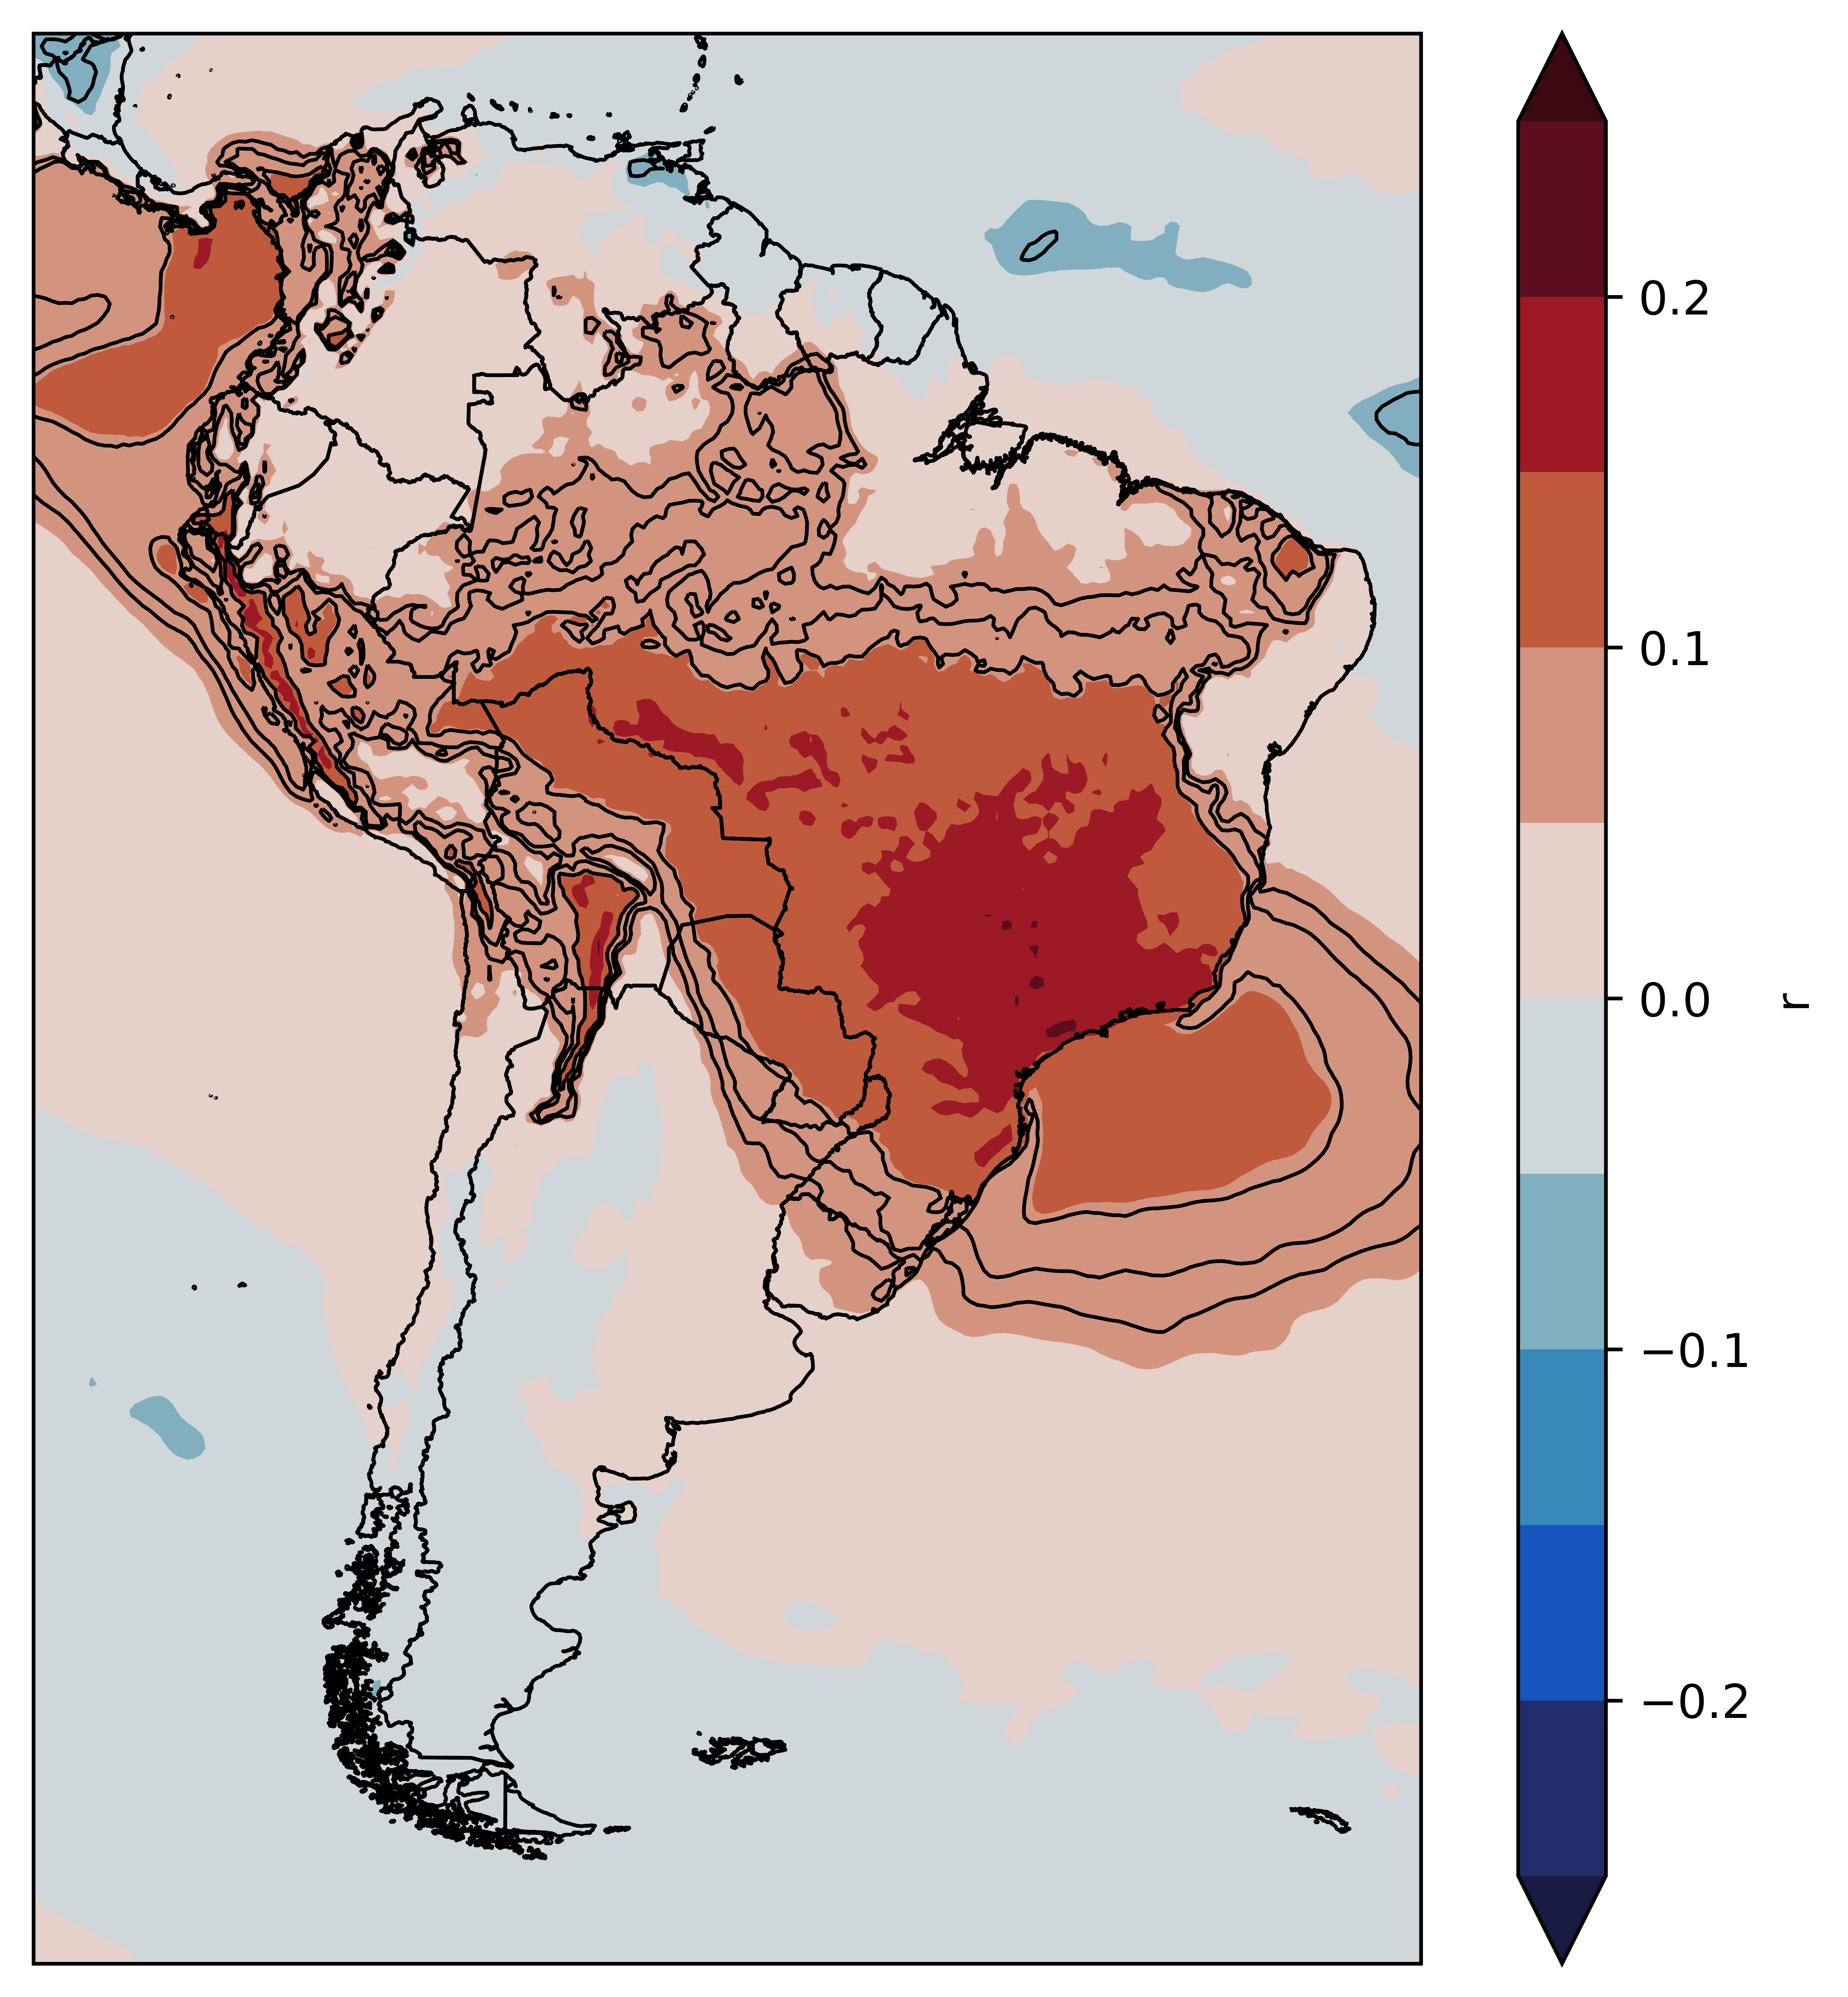

In [54]:
# Create a plot with a PlateCarree projection
fig, ax = plt.subplots(figsize=(5.5,5.5), dpi=1000, subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the GeoDataFrame with country boundaries
df_paises.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

# Overlay the contour plot of the Iris cube
cmap = cmocean.cm.balance
contour = iplt.contourf(r_cube[0, :, :], levels=np.arange(-0.25, 0.30, 0.05), extend='both', cmap=cmap)
plt.colorbar(label="r")
iplt.contour(pvalues_cube[0, :, :], levels=[0.01], colors='white', linestyle= "-", linewidths=0.8)  # 99%
iplt.contour(pvalues_cube[0, :, :], levels=[0.05], colors='white', linestyle= "-", linewidths=0.8)  # 95%
iplt.contour(pvalues_cube[0, :, :], levels=[0.10], colors='white', linestyle= "-", linewidths=0.8)  # 90%
# Set the spatial limits
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
plt.title("Regression: t2m - CI Corrientes")

AttributeError: 'list' object has no attribute 'boundary'

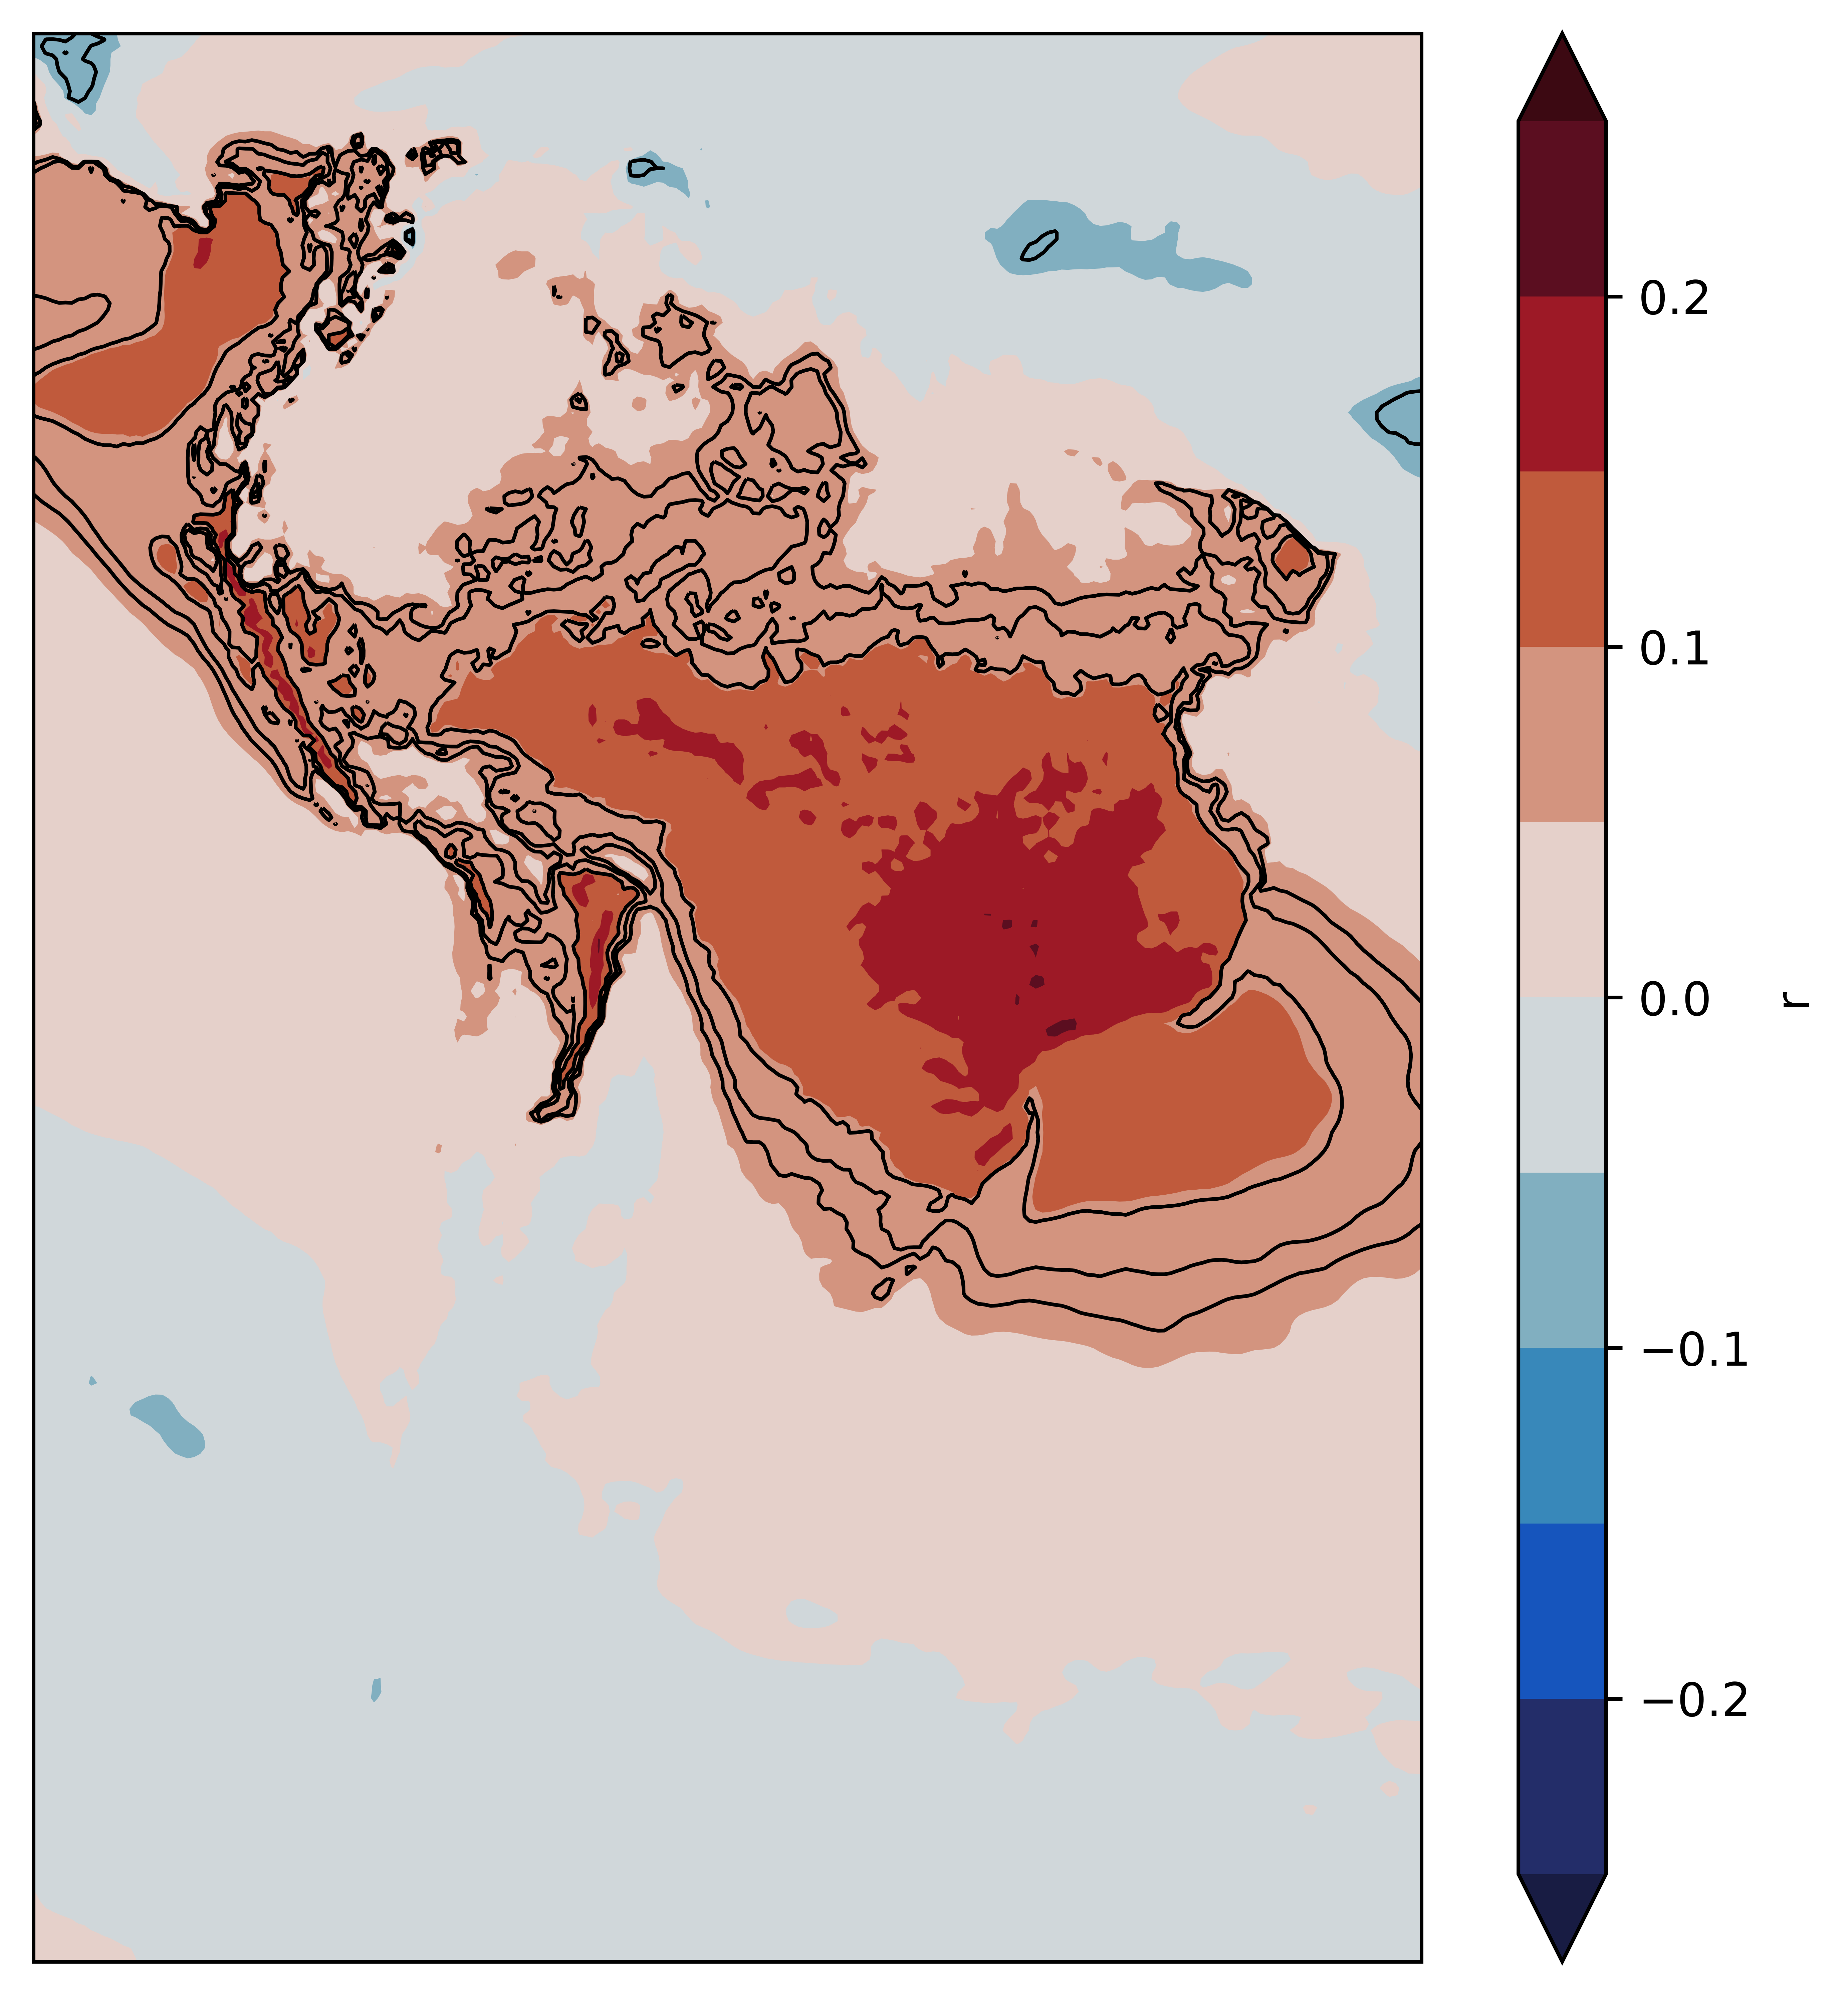

In [31]:
#plot 
plt.figure(figsize=(7.5,7.5), dpi=1000)
#cmap = plt.get_cmap("brewer_RdYlBu_11")
cmap = cmocean.cm.balance
iplt.contourf(r_cube[0,:,:], levels=np.arange(-0.25, 0.30, 0.05),  extend='both', cmap=cmap) 
plt.colorbar(label="r")
iplt.contour(pvalues_cube[0, :, :], levels=[0.01], colors='black', linewidths=0.8)  # 99%
iplt.contour(pvalues_cube[0, :, :], levels=[0.05], colors='black', linewidths=0.8)  # 95%
iplt.contour(pvalues_cube[0, :, :], levels=[0.10], colors='black', linewidths=0.8)  # 90%
paises.boundary.plot(ax=plt.gca(), linewidth=1, color='black')

#iplt.add_geometries(paises, crs=ccrs.PlateCarree(), facecolor='none',
 #                           edgecolor='0.4', alpha=0.9)
plt.title("Regression: t2m - CI Corrientes")
iplt.plt.gca().coastlines()